In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
import os

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os.path
from textwrap import wrap
from utils import preprocess_captions
from data import *

if not os.path.exists(PATH_PRE+"/data/captions.json"):
    preprocess_captions()

In [4]:
batch_size = 2
loader = get_loader("COMPLETE", batch_size)

In [5]:
torch.cuda.is_available()

True

## Exploratory Data Analysis

In [6]:
print("Vocab size:", len(loader.dataset.vocab))
print("Total captions:", len(loader.dataset.captions))

Vocab size: 1842
Total captions: 40453


Text(0.5, 0, 'Words')

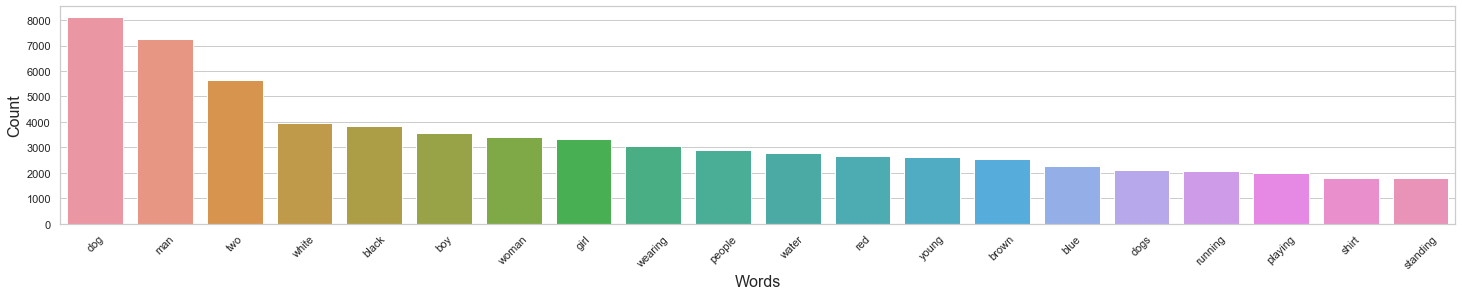

In [36]:
#
# Vocab word frequency distribution
#
word_freq = loader.dataset.vocab.words_freq
top50 = word_freq.most_common(20)
x = [x for x, y in top50]
y = [y for x, y in top50]

sns.set(style="whitegrid")
plt.figure(figsize=(25, 4))

ax = sns.barplot(x=x, y=y)
plt.xticks(rotation=45)
plt.ylabel('Count', fontsize=16)
plt.xlabel('Words', fontsize=16)

Text(0.5, 0, 'Words')

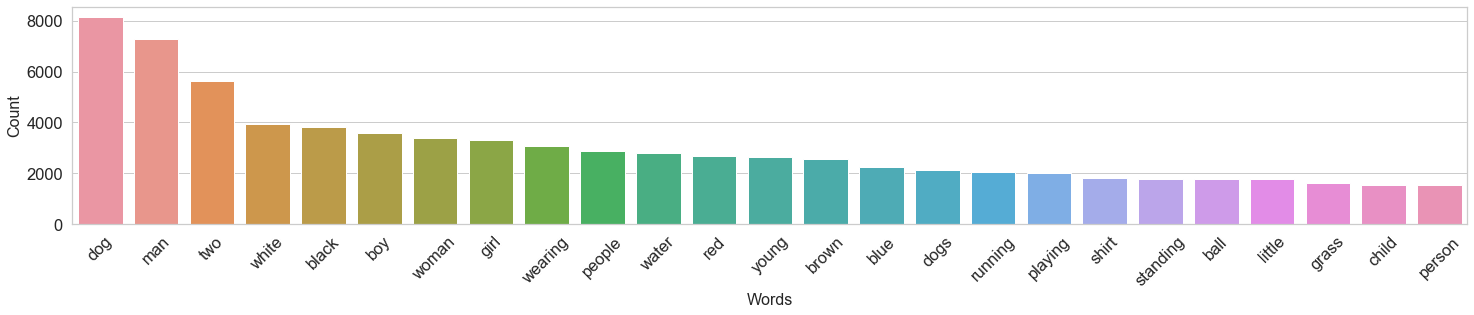

In [41]:
from wordcloud import STOPWORDS

filtered = word_freq
for word in list(filtered):
    if word in STOPWORDS:
        del filtered[word]
        
top50 = filtered.most_common(25)
x = [x for x, y in top50]
y = [y for x, y in top50]

sns.set(style="whitegrid", font_scale = 1.5)
plt.figure(figsize=(25, 4))
ax = sns.barplot(x=x, y=y)
plt.xticks(rotation=45)
plt.ylabel('Count', fontsize=16)
plt.xlabel('Words', fontsize=16)

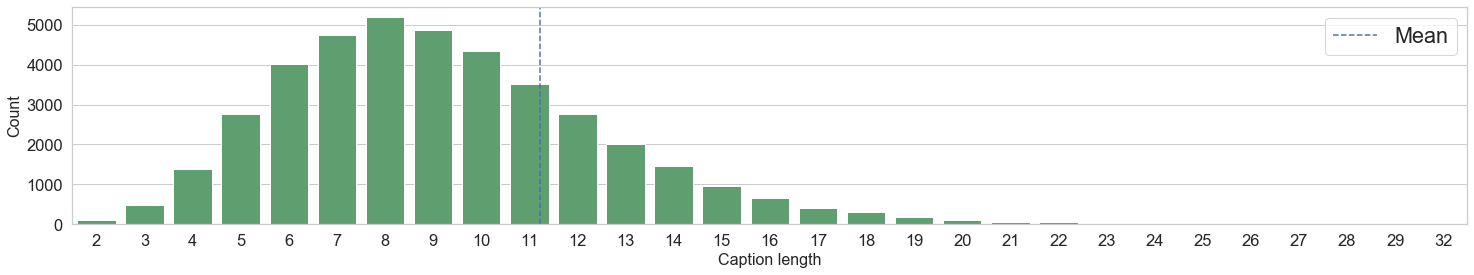

In [43]:
#
# Caption lengths distribution
#

lengths = loader.dataset.caption_lengths
mean = sum(lengths)/len(lengths)
sns.set(style="whitegrid", font_scale = 1.5)
plt.figure(figsize=(25, 4))
ax = sns.countplot(lengths, color="g")
plt.xlabel('Caption length', fontsize=16)
plt.ylabel('Count', fontsize=16)
ax.axvline(mean, color='b', linestyle='--')
plt.legend({'Mean': mean}, fontsize="large")



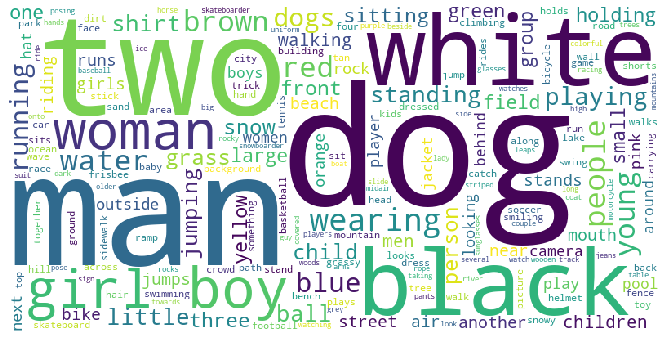

In [22]:
from wordcloud import WordCloud, STOPWORDS

filtered = word_freq
for word in list(filtered):
    if word in STOPWORDS:
        del filtered[word]

wordcloud = WordCloud(width=800, height=400, background_color="white").generate_from_frequencies(filtered)
plt.figure(figsize=(20, 6))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

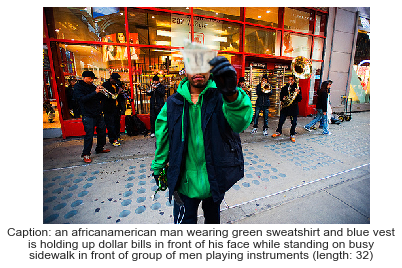

In [11]:
image, caption = loader.dataset.get_raw_item(lengths.index(max(lengths)))
caption = "Caption: {} (length: {})".format(caption, max(lengths))
sns.set(style="white")
plt.axis('off')
plt.imshow(np.squeeze(image))
#plt.title('Maximum caption length image')
plt.figtext(0.5, 0.01, "\n".join(wrap(caption)), ha='center', wrap=True, fontsize=12)
plt.show()

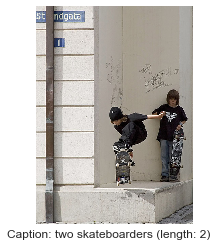

In [12]:
image, caption = loader.dataset.get_raw_item(lengths.index(min(lengths)))
caption = "Caption: {} (length: {})".format(caption, min(lengths))
sns.set(style="white")
plt.axis('off')
plt.imshow(np.squeeze(image))
#plt.title('Minimum caption length image')
plt.figtext(0.5, 0.08, "\n".join(wrap(caption)), ha='center', wrap=True, fontsize=12)
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


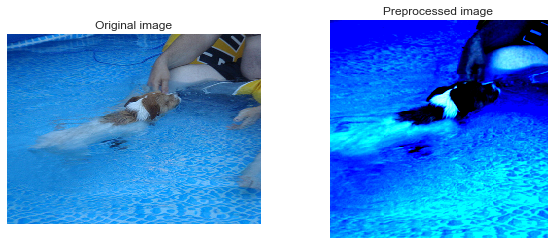

In [34]:
test_loader = get_loader("TEST", 1)
iter_loader = iter(test_loader)

orig_image, image, encoded_captions = next(iter_loader)
image = image.numpy()
image = np.squeeze(image)
image = image.transpose((1, 2, 0))
#image = (image - image.min()) / (image.max() - image.min()) 

plt.figure(figsize=(10,4))
plt.subplot(1, 2, 1), plt.imshow(np.squeeze(orig_image))
plt.axis('off')
plt.title('Original image')

plt.subplot(1, 2, 2), plt.imshow(image)
plt.axis('off')
plt.title('Preprocessed image')
plt.show()

## Functionality tests

In [14]:
#
# Same-length indices sampler test
#

import torch.utils.data as data

# Randomly sample a caption length and 
# sample indices of captions with that length
indices, length = loader.dataset.get_indices(True)
print('# of sampled indices with length {}: {}'.format(length, len(indices)))
print('Indices: {}'.format(indices))

# Batch sampler
sampler = data.sampler.SubsetRandomSampler(indices=indices)
loader.batch_sampler.sampler = sampler

# Obtain  batch
iter_loader = iter(loader)
images, captions = next(iter_loader)
    
print('images.shape:', images.shape)
# The length of the captions is +2 for the <start> and <end> tokens
print('captions.shape:', captions.shape)

# of sampled indices with length 11: 2
Indices: [35728, 3526]
images.shape: torch.Size([2, 3, 224, 224])
captions.shape: torch.Size([2, 13])


In [15]:
#
# Encoder and Decoder forward pass test
#

from models import Encoder, Decoder

embed_size = 256
momentum = 0.01
encoder = Encoder(embed_size, momentum)

hidden_size = 512
vocab_size = len(loader.dataset.vocab)
decoder = Decoder(embed_size, hidden_size, vocab_size)

if batch_size == 1:
    encoder.eval() # Don't use batch norm when I'm testing with batch size=1

if torch.cuda.is_available():
    encoder = encoder.cuda()
    decoder = decoder.cuda()
    images = images.cuda()
    captions = captions.cuda()
    
features = encoder(images)
outputs = decoder(features, captions)

# Features shape should be (batch_size, embed_size)
print(features.shape)

# Outputs shape should be (batch_size, captions.shape[1], vocab_size)
print(outputs.shape)

torch.Size([2, 256])
torch.Size([2, 13, 1842])


In [16]:
#
# Encoder and Decoder backward pass test
#
import torch
from torch import nn

criterion = nn.CrossEntropyLoss().cuda()
params = (list(filter(lambda p: p.requires_grad, encoder.parameters()))+
        list(filter(lambda p: p.requires_grad, decoder.parameters())))
optimizer = torch.optim.Adam(params, lr=0.001)

loss = criterion(outputs.view(-1, len(loader.dataset.vocab)), 
                 captions.view(-1))
optimizer.zero_grad()
loss.backward()
optimizer.step()

In [17]:
#
# Validation loader test
#

embed_size = 256
momentum = 0.01
encoder = Encoder(embed_size, momentum)

hidden_size = 512
vocab_size = len(loader.dataset.vocab)
decoder = Decoder(embed_size, hidden_size, vocab_size)

encoder.eval()
decoder.eval()

val_loader = get_loader("VAL", 2)

# Randomly sample a caption length, and sample indices with that length.
indices = val_loader.dataset.get_indices()
# Create and assign a batch sampler to retrieve a batch with the sampled indices.
sampler = data.sampler.SubsetRandomSampler(indices=indices)
val_loader.batch_sampler.sampler = sampler

# Obtain batch
iter_loader = iter(val_loader)
images, captions, all_caps = next(iter_loader)

if torch.cuda.is_available():
    encoder = encoder.cuda()
    decoder = decoder.cuda()
    images = images.cuda()
    captions = captions.cuda()
    
features = encoder(images)
outputs = decoder(features, captions)

# features shape should be (batch_size, embed_size)
print(features.shape)

# outputs shape should be (batch_size, captions.shape[1], vocab_size)
print(outputs.shape)

# all_caps shape should be (batch_size, #caption per image, max_caption_length)
print(all_caps.shape)

torch.Size([2, 256])
torch.Size([2, 7, 1842])
torch.Size([2, 5, 31])


In [18]:
#
# Batched BLEU scoring test
#
from train_utils import bleu_eval

_, predicted = outputs.max(2)
candidates = predicted.to("cpu").numpy()
batch_bleu_score = bleu_eval(candidates, all_caps, val_loader.dataset.vocab)
batch_bleu_score

0.019640732545025654

In [19]:
#
# Early stopping test, check function definition for details
#
from train_utils import early_stopping

a = [1, 1, 1, 5, 1, 1, 1] # last 3 are the same, true
print(early_stopping(a))
a = [1, 1, 1, 5, 6, 1, 1] # last 3 are different, false
print(early_stopping(a))
a = [1, 2, 3, 4, 5, 6, 7] # last 3 are different, false
print(early_stopping(a))
a = [0.052, 0.050, 0.053] # last 3 are different but are very close (std dev betweeb them is less than 0.02)
print(early_stopping(a))

True
False
False
True


In [20]:
#
# Saving checkpoint test
#
import os
epoch = 1
i = 1
filename = os.path.join("../data/models/checkpoints/tmp-model-{}-{}.ckpt".format(epoch, i))
print(filename)
torch.save({"encoder": encoder.state_dict(),
            "decoder": decoder.state_dict(),
            "optimizer" : optimizer.state_dict(),
            "total_loss": 0,
            "epoch": epoch,
            "train_step": i,
        }, filename)

../data/models/checkpoints/tmp-model-1-1.ckpt


FileNotFoundError: [Errno 2] No such file or directory: '../data/models/checkpoints/tmp-model-1-1.ckpt'